In [1]:
%load_ext autoreload
%autoreload 2
%cd "~/deepshape/deepshape"

/home/jorgen/deepshape/deepshape


In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [8]:
from curves import *
from layers import *
from visual import *
from networks import ReparametrizationNetwork1D, train
from relu_layer import *
from palais_layer import *

In [9]:
# Figures folder
figdir = "/home/jorgen/deepshape/figures/srvt/"

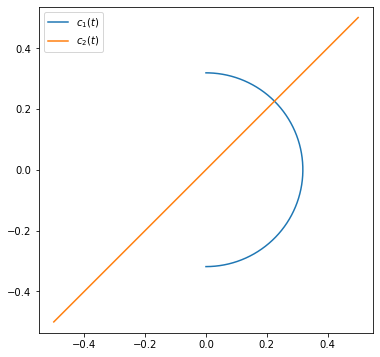

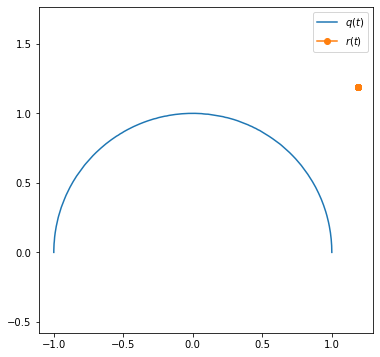

In [10]:
c1 = Curve((
    lambda x: torch.sin(np.pi * x) / np.pi, 
    lambda x: torch.cos(np.pi * (x+1.)) / np.pi
))
c2 = Curve((lambda x: torch.zeros_like(x), lambda x: x - 0.5))
c2 = Curve((lambda x: x - 0.5, lambda x: x - 0.5))

g = Diffeomorphism(lambda x: x - torch.sin(2*np.pi*x) / (2 * np.pi))


q = SRVT(c1)
r = SRVT(c2)

fig, ax = plt.subplots(figsize=(6,6))
plot_curve(c1, ax=ax, label="$c_1(t)$")
plot_curve(c2, ax=ax, label="$c_2(t)$")
plt.legend()
plt.axis("equal")
plt.savefig(figdir + "curves.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(6,6))
plot_curve(q, ax=ax, label="$q(t)$")
plot_curve(r, ax=ax, marker='o', label="$r(t)$")
plt.legend()
plt.axis("equal")
plt.savefig(figdir + "srvts.pdf")
plt.show()

In [11]:
RN = ReparametrizationNetwork1D(4, 10, init_scale=0.0)
opt = optim.SGD(RN.parameters(), lr=1e-3)
error = train(q, r, RN, opt, loss=nn.MSELoss(), iterations=500, npoints=1024, log_every=50)
x = torch.linspace(0, 1, 1024)
z, y, Q, R = get_plot_data1D(q, r, RN, 1024)

[Iter     1] loss: 1.15832
[Iter    51] loss: 0.93442
[Iter   101] loss: 0.87549
[Iter   151] loss: 0.84365
[Iter   201] loss: 0.82238
[Iter   251] loss: 0.80831
[Iter   301] loss: 0.80153
[Iter   351] loss: 0.79767
[Iter   401] loss: 0.79530
[Iter   451] loss: 0.79389

Finished training in 1.87363s


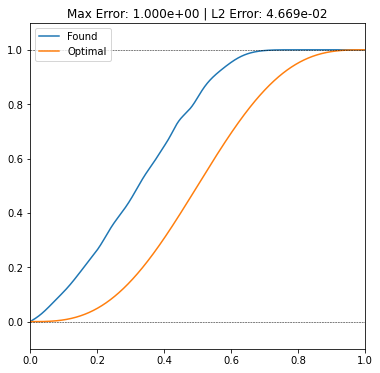

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(x, z, label="Found")
plt.plot(x, g(x), label="Optimal")
plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim(-0.1, 1.1)
plt.axhline(0, ls="--", lw=0.5, c="k")
plt.axhline(1, ls="--", lw=0.5, c="k")
plt.savefig(figdir + "reparametrization-compare.pdf")
plt.title(f"Max Error: {torch.abs(z - g(x)).max():.3e} | L2 Error: {nn.MSELoss()(z.squeeze(), g(x)):.3e}")
plt.show()


Finished training in 1.87720s


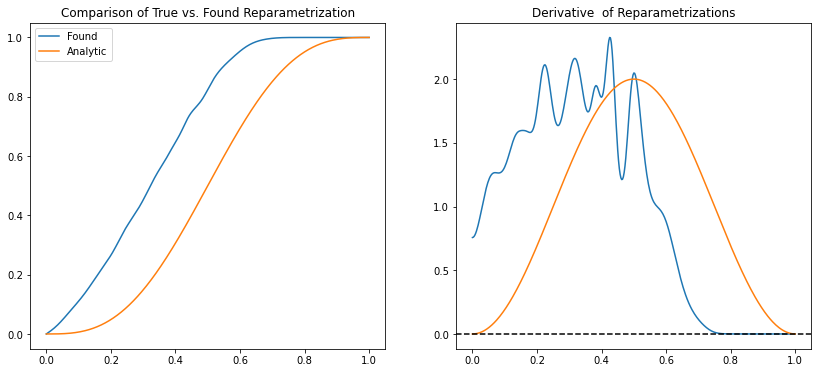

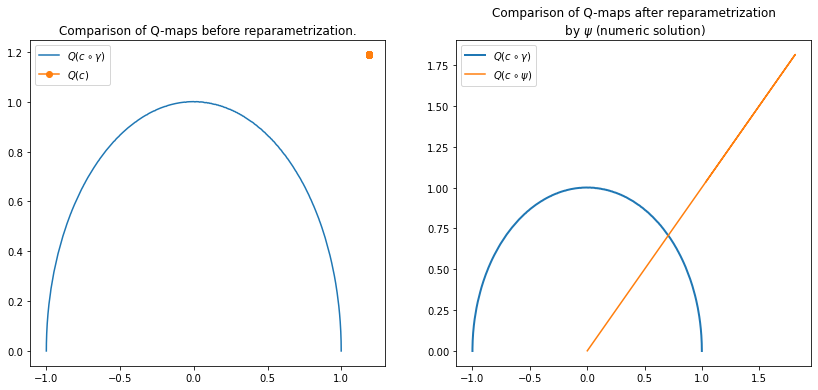

In [13]:
RN = ReparametrizationNetwork1D(4, 10, init_scale=0.0)

# Choose and configure optimizer.
# opt = optim.Adam(RN.parameters(), lr=1e-3)
opt = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.1)
# opt = optim.RMSprop(RN.parameters(), lr=1e-4)

# Train network
error = train(q, r, RN, opt, loss=nn.MSELoss(), iterations=500, npoints=1024, log_every=0)

# Create Plotting Data to verify reparametrizations
x = torch.linspace(0, 1, 401).unsqueeze(-1)
z, y = RN(x)
z, y = z.detach(), y.detach()
Q, R = q(x), RN.reparametrized(r, x)
R = R.detach()

# Plot Diffeomorphism...
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x, z, label="Found")
plt.plot(x, g(x), label="Analytic")
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()

# ... and derivative to check if strictly positive
plt.subplot(1, 2, 2)
plt.plot(x, y, label="Found")
plt.plot(x, g.derivative(x), label="Analytic")
plt.axhline(0, ls='--', c='k')
plt.title("Derivative  of Reparametrizations")
plt.savefig(figdir + "reparametrizations.pdf")
plt.show()


# Plot Q-maps, and compare 
plt.figure(figsize=(14, 6))
# Before 
plt.subplot(1, 2, 1)
plt.plot(q(x)[:, 0], q(x)[:, 1], label="$Q(c \circ \gamma)$")
plt.plot(r(x)[:, 0], r(x)[:, 1], label="$Q(c)$", marker='o')
plt.title("Comparison of Q-maps before reparametrization.")
plt.legend()

# .. and after reparametrization
plt.subplot(1, 2, 2)
plt.plot(Q[:, 0], Q[:, 1], label="$Q(c \circ \gamma)$", lw=2)
plt.plot(R[:, 0], R[:, 1], label="$Q(c \circ \psi)$")
plt.title("Comparison of Q-maps after reparametrization\n by $\psi$ (numeric solution)")
plt.legend()
plt.savefig(figdir + "qmaps.pdf")
plt.show()

## Convergence Plots for Optimizers


Adam

[Iter     1] loss: 0.36409
[Iter   101] loss: 0.30380

Finished training in 0.71916s

SGD

[Iter     1] loss: 0.36409
[Iter   101] loss: 0.30024

Finished training in 0.68448s

SGD w/Momentum

[Iter     1] loss: 0.36409
[Iter   101] loss: 0.34718

Finished training in 0.71010s

RMSProp

[Iter     1] loss: 0.36409
[Iter   101] loss: 0.33791

Finished training in 0.65728s


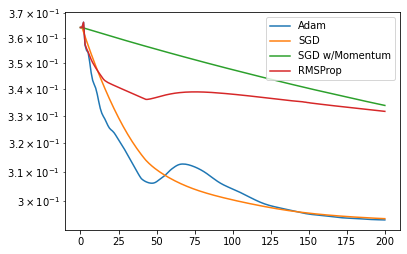

In [14]:
optimizers = {
    "Adam" : [optim.Adam, {"lr": 1e-3}],
    "SGD" : [optim.SGD, {"lr": 1e-3}],
    "SGD w/Momentum": [optim.SGD, {"lr": 1e-4, "momentum": 0.01}],
    "RMSProp": [optim.RMSprop, {"lr": 1e-4}]
}

errors = {}
for optimizer, config in optimizers.items():
    print("=" * 80)
    print()
    print(optimizer)
    print()
    RN = ReparametrizationNetwork1D(3, 20, init_scale=0.)
    opt = config[0](RN.parameters(), **config[1])
    errors[optimizer] = train(q, r, RN, opt, loss=nn.MSELoss(), iterations=200, npoints=1024, log_every=100)

fig, ax = plt.subplots()
for optimizer, error in errors.items():
    plt.plot(error, label=optimizer)
plt.legend()
plt.yscale("log")
plt.show()

In [17]:
lt = TangentReluLayer1D(10, 20)

In [19]:
isinstance(lt, FourierLayer1D)

False

In [58]:
RN = ReparametrizationNetwork1D(4, 10, init_scale=1e-1, layer_type=TangentReluLayer1D)
opt = optim.SGD(RN.parameters(), lr=1e-3)
error = train(q, r, RN, opt, loss=nn.MSELoss(), iterations=500, npoints=1024, log_every=50)
x = torch.linspace(0, 1, 1024)
z, y, Q, R = get_plot_data1D(q, r, RN, 1024)

[Iter     1] loss: 1.13940
[Iter    51] loss: 1.12587
[Iter   101] loss: 1.11759
[Iter   151] loss: 1.11193
[Iter   201] loss: 1.10756
[Iter   251] loss: 1.10374
[Iter   301] loss: 1.10015
[Iter   351] loss: 1.09652
[Iter   401] loss: 1.09274
[Iter   451] loss: 1.08877

Finished training in 2.93772s


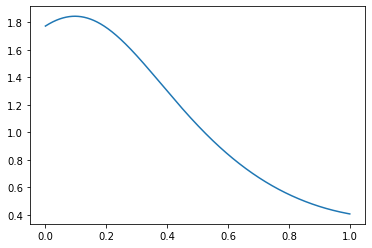

In [61]:
plt.plot(x, y)

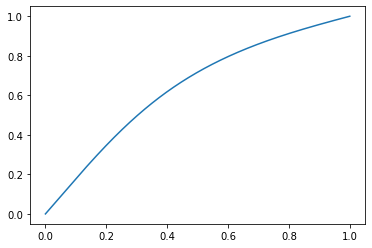

In [62]:
plt.plot(x, z)

In [46]:
l = nn.Linear(3, 1)

In [51]:
with torch.no_grad(): 
    l.weight *= 0.

In [53]:
l.bias

Parameter containing:
tensor([0.1277], requires_grad=True)